## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

## датасет

In [3]:
import os
import shutil 
from tqdm import tqdm

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


сперва разархивировать!

In [5]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/data.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
data_root = 'data'
train_dir = 'train'
val_dir = 'val'

num_classes = 50
class_names = [str(i) for i in range(num_classes)]

In [7]:
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

sum = 0
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    # Split on train and validation set
    num_images = len(os.listdir(source_dir))
    val_part = 0.2
    num_val_images = int(val_part * num_images)
    # every flag-th image to validation
    flag = num_images // num_val_images

    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):    
        sum += 1
        if i % flag != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

print(sum)

100%|██████████| 129/129 [00:00<00:00, 4685.56it/s]

7166


## подготовка данных

In [8]:
import torch
from torchvision import transforms, datasets

всячески трансформируем данные для обучения, чтобы усложнить тренировку: повернем случайным образом, отразим

In [9]:
mean = [0.485, 0.456, 0.406]    
std = [0.229, 0.224, 0.225] 
h = 224
w = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=25),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [10]:
train_dataset = datasets.ImageFolder(train_dir, train_transforms)
val_dataset = datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## примеры фото пёселей

In [11]:
import matplotlib.pyplot as plt

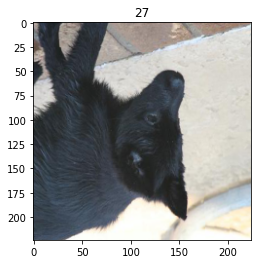

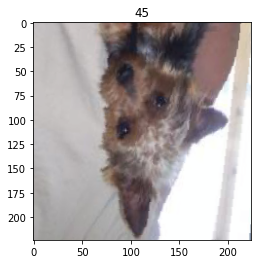

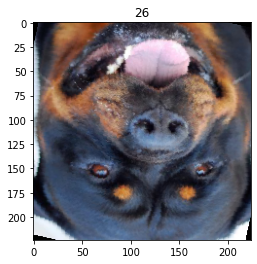

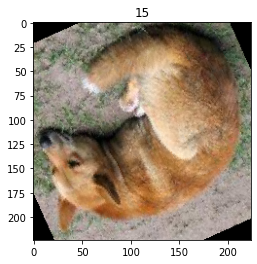

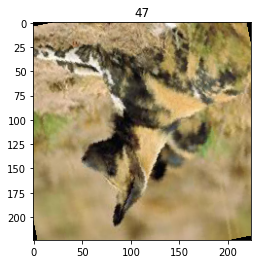

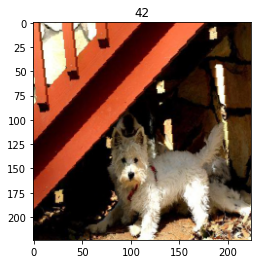

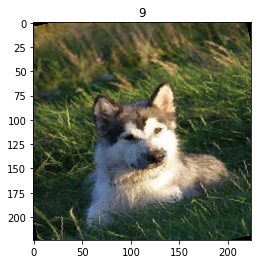

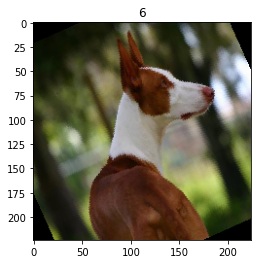

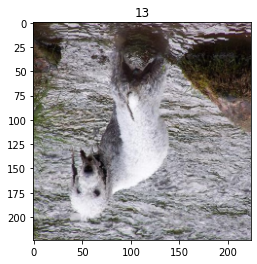

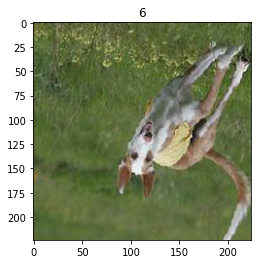

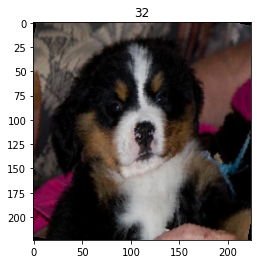

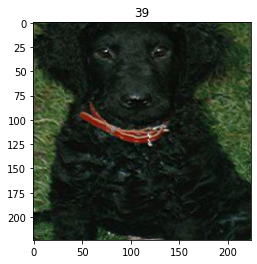

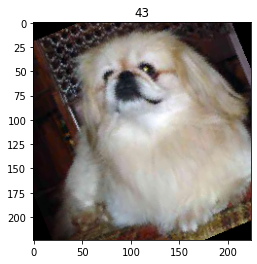

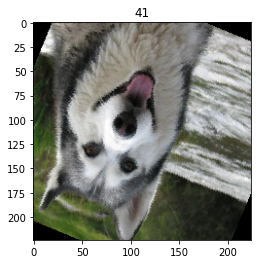

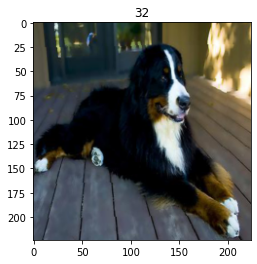

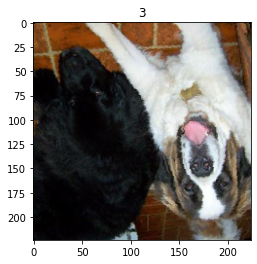

In [12]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## модель
#### буду брать за основу densenet161, но заменю последний слой на линейный с количеством выходов 50 (количество пород пёселей) 

In [13]:
from torchvision import models

In [14]:
model = models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [15]:
#заимпортим, чтобы не было ошибки: image file is truncated (0 bytes not processed)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
def train_model(model, loss, optimizer, num_epochs):
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(1, num_epochs+1):
        print('epoch {}/{}:'.format(epoch, num_epochs), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            print('{}\nloss: {:.4f}\nacc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [17]:
model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, loss, optimizer, num_epochs=15);

epoch 1/15:


100%|██████████| 358/358 [02:35<00:00,  2.31it/s]

train
loss: 2.0131
acc: 0.5389




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.4950
acc: 0.9190

epoch 2/15:



100%|██████████| 358/358 [02:35<00:00,  2.31it/s]

train
loss: 0.9919
acc: 0.7399




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.3399
acc: 0.9196

epoch 3/15:



100%|██████████| 358/358 [02:34<00:00,  2.32it/s]

train
loss: 0.8365
acc: 0.7680




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.2948
acc: 0.9238

epoch 4/15:



100%|██████████| 358/358 [02:35<00:00,  2.31it/s]

train
loss: 0.7349
acc: 0.7913




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.2414
acc: 0.9379

epoch 5/15:



100%|██████████| 358/358 [02:34<00:00,  2.31it/s]

train
loss: 0.6869
acc: 0.7996




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.2417
acc: 0.9354

epoch 6/15:



100%|██████████| 358/358 [02:34<00:00,  2.31it/s]

train
loss: 0.6205
acc: 0.8177




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.2422
acc: 0.9296

epoch 7/15:



100%|██████████| 358/358 [02:34<00:00,  2.31it/s]

train
loss: 0.6119
acc: 0.8183




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.2518
acc: 0.9272

epoch 8/15:



100%|██████████| 358/358 [02:34<00:00,  2.31it/s]

train
loss: 0.5866
acc: 0.8227




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.2473
acc: 0.9238

epoch 9/15:



100%|██████████| 358/358 [02:34<00:00,  2.31it/s]

train
loss: 0.5605
acc: 0.8316




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.1995
acc: 0.9416

epoch 10/15:



100%|██████████| 358/358 [02:35<00:00,  2.30it/s]

train
loss: 0.5401
acc: 0.8365




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.2287
acc: 0.9334

epoch 11/15:



100%|██████████| 358/358 [02:34<00:00,  2.31it/s]

train
loss: 0.5130
acc: 0.8431




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.2086
acc: 0.9368

epoch 12/15:



100%|██████████| 358/358 [02:34<00:00,  2.32it/s]

train
loss: 0.5036
acc: 0.8486




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.2535
acc: 0.9231

epoch 13/15:



100%|██████████| 358/358 [02:35<00:00,  2.30it/s]

train
loss: 0.5127
acc: 0.8437




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.2245
acc: 0.9299

epoch 14/15:



100%|██████████| 358/358 [02:35<00:00,  2.31it/s]

train
loss: 0.4850
acc: 0.8483




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.2175
acc: 0.9361

epoch 15/15:



100%|██████████| 358/358 [02:34<00:00,  2.31it/s]

train
loss: 0.4497
acc: 0.8631




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.2165
acc: 0.9382



## графики 1

Text(0.5, 1.0, 'train & val')

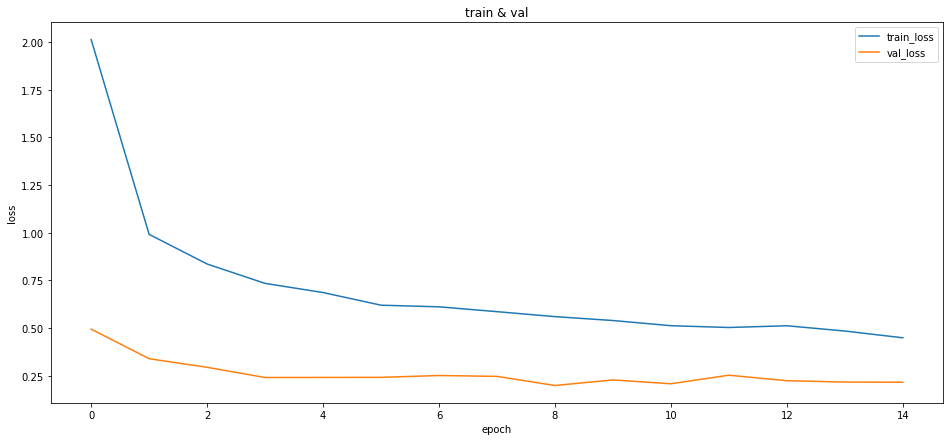

In [18]:
plt.figure(figsize=(16, 7))
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train & val')

Text(0.5, 1.0, 'train & val')

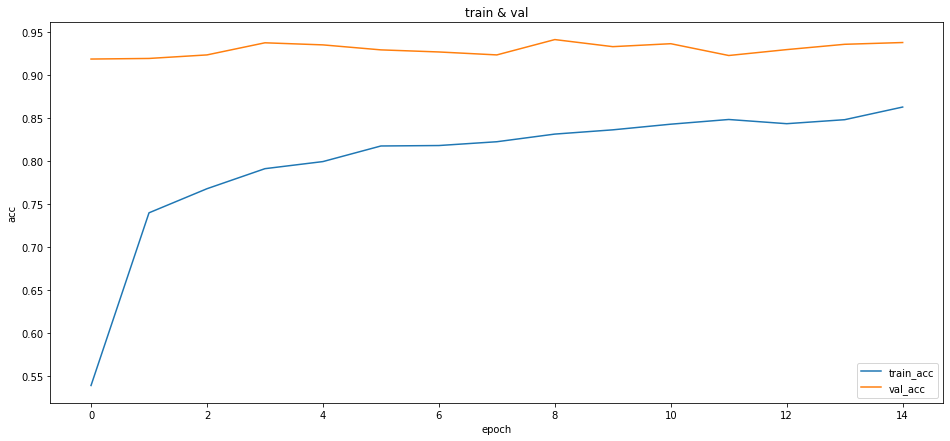

In [19]:
plt.figure(figsize=(16, 7))
plt.plot(train_acc_history, label='train_acc')
plt.plot(val_acc_history, label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('train & val')

#### графики loss и acc стремятся к константе, поэтому считаем, что модель обучилась. при это переобучения не наблюдается
#### теперь обучем на всех данных

## треннировка на всех данных

In [20]:
train_dir = 'data/train'
train_dataset = datasets.ImageFolder(train_dir, train_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
model_full = models.densenet161(pretrained=True)

for param in model_full.parameters():
    param.requires_grad = False

model_full.classifier = torch.nn.Linear(model_full.classifier.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_full = model_full.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_full.parameters(), lr=1.0e-3)

In [22]:
model_full, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model_full, loss, optimizer, num_epochs=15);

epoch 1/15:


100%|██████████| 448/448 [03:13<00:00,  2.31it/s]

train
loss: 1.8452
acc: 0.5738




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.3942
acc: 0.9344

epoch 2/15:



100%|██████████| 448/448 [03:14<00:00,  2.30it/s]

train
loss: 0.9387
acc: 0.7456




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.2413
acc: 0.9485

epoch 3/15:



100%|██████████| 448/448 [03:14<00:00,  2.30it/s]

train
loss: 0.7775
acc: 0.7803




100%|██████████| 91/91 [00:37<00:00,  2.41it/s]

val
loss: 0.2064
acc: 0.9492

epoch 4/15:



100%|██████████| 448/448 [03:13<00:00,  2.31it/s]

train
loss: 0.7072
acc: 0.7966




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.1671
acc: 0.9540

epoch 5/15:



100%|██████████| 448/448 [03:13<00:00,  2.32it/s]

train
loss: 0.6526
acc: 0.8118




100%|██████████| 91/91 [00:37<00:00,  2.44it/s]

val
loss: 0.1563
acc: 0.9560

epoch 6/15:



100%|██████████| 448/448 [03:13<00:00,  2.31it/s]

train
loss: 0.6273
acc: 0.8142




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.1443
acc: 0.9602

epoch 7/15:



100%|██████████| 448/448 [03:13<00:00,  2.31it/s]

train
loss: 0.5945
acc: 0.8232




100%|██████████| 91/91 [00:37<00:00,  2.44it/s]

val
loss: 0.1358
acc: 0.9657

epoch 8/15:



100%|██████████| 448/448 [03:13<00:00,  2.32it/s]

train
loss: 0.5861
acc: 0.8278




100%|██████████| 91/91 [00:37<00:00,  2.44it/s]

val
loss: 0.1152
acc: 0.9650

epoch 9/15:



100%|██████████| 448/448 [03:12<00:00,  2.32it/s]

train
loss: 0.5672
acc: 0.8250




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.1133
acc: 0.9718

epoch 10/15:



100%|██████████| 448/448 [03:13<00:00,  2.31it/s]

train
loss: 0.5483
acc: 0.8328




100%|██████████| 91/91 [00:37<00:00,  2.43it/s]

val
loss: 0.0961
acc: 0.9753

epoch 11/15:



100%|██████████| 448/448 [03:13<00:00,  2.31it/s]

train
loss: 0.5146
acc: 0.8409




100%|██████████| 91/91 [00:37<00:00,  2.42it/s]

val
loss: 0.0979
acc: 0.9718

epoch 12/15:



100%|██████████| 448/448 [03:15<00:00,  2.29it/s]

train
loss: 0.5284
acc: 0.8407




100%|██████████| 91/91 [00:37<00:00,  2.41it/s]

val
loss: 0.1091
acc: 0.9650

epoch 13/15:



100%|██████████| 448/448 [03:14<00:00,  2.30it/s]

train
loss: 0.5097
acc: 0.8436




100%|██████████| 91/91 [00:37<00:00,  2.40it/s]

val
loss: 0.0958
acc: 0.9732

epoch 14/15:



100%|██████████| 448/448 [03:16<00:00,  2.28it/s]

train
loss: 0.5046
acc: 0.8459




100%|██████████| 91/91 [00:38<00:00,  2.38it/s]

val
loss: 0.0857
acc: 0.9780

epoch 15/15:



100%|██████████| 448/448 [03:17<00:00,  2.27it/s]

train
loss: 0.4871
acc: 0.8494




100%|██████████| 91/91 [00:37<00:00,  2.40it/s]

val
loss: 0.0880
acc: 0.9705



## графики 2

Text(0.5, 1.0, 'train & val')

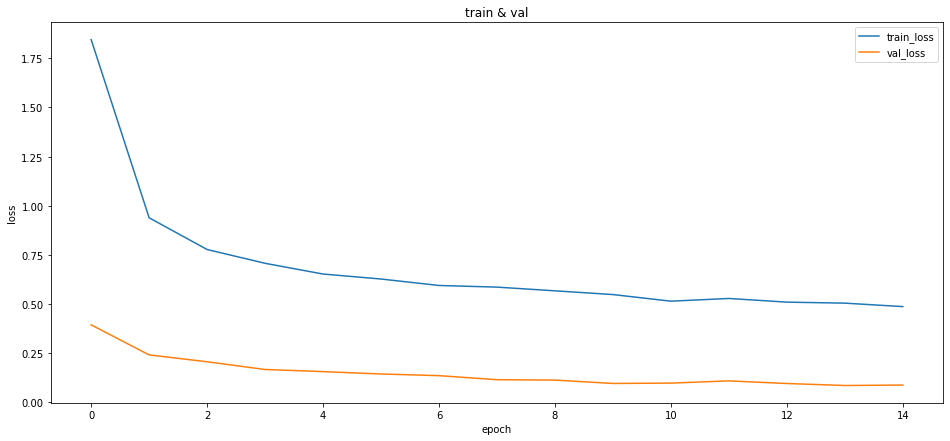

In [23]:
plt.figure(figsize=(16, 7))
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train & val')

Text(0.5, 1.0, 'train & val')

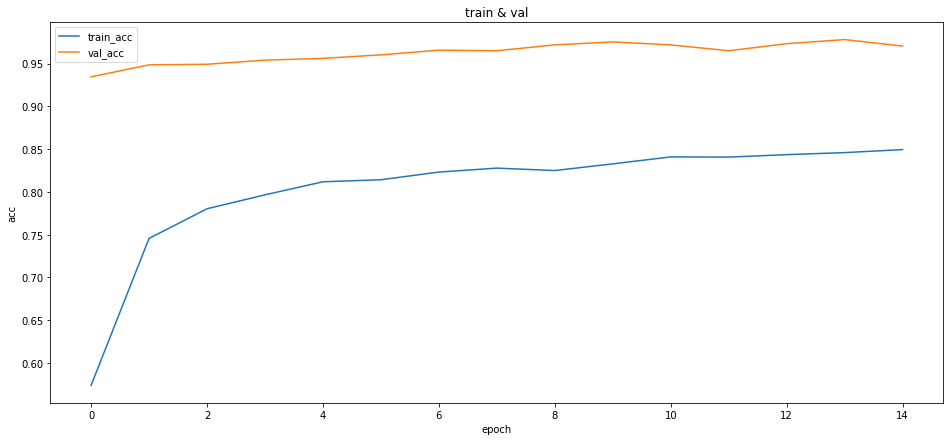

In [24]:
plt.figure(figsize=(16, 7))
plt.plot(train_acc_history, label='train_acc')
plt.plot(val_acc_history, label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('train & val')

## csv с предсказаниями и еще немного фото пёселей

In [25]:
import torchvision
import numpy as np
import pandas as pd
from IPython.display import HTML
import base64

In [26]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [27]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [28]:
model_full.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model_full(inputs)
    test_predictions.append(
        torch.argmax(preds, dim=1).data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

  0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 94/94 [00:33<00:00,  2.79it/s]


#### еще фотографии пёселей

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


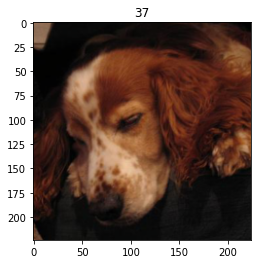

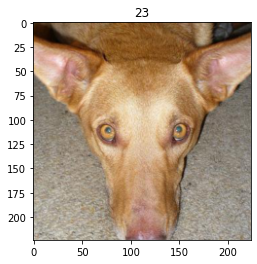

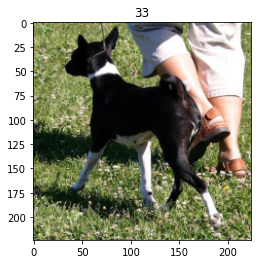

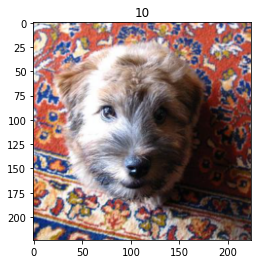

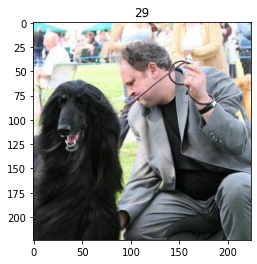

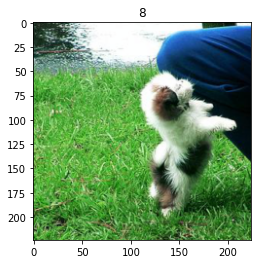

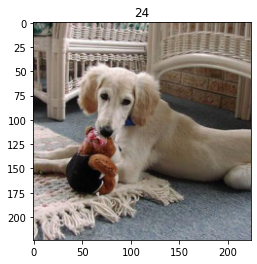

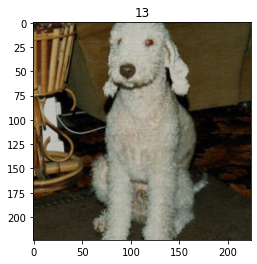

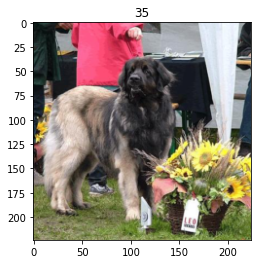

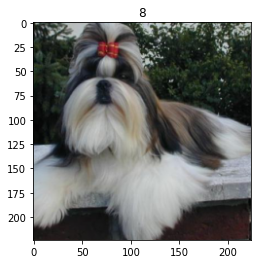

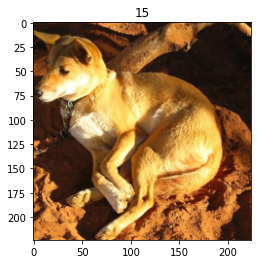

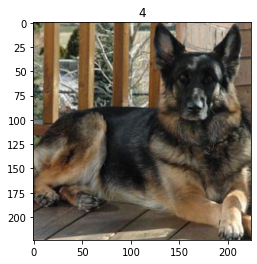

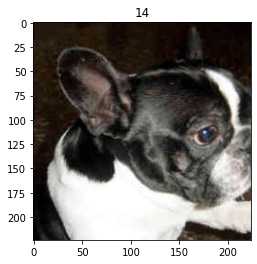

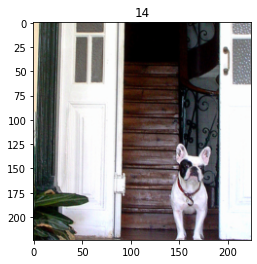

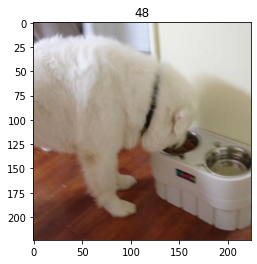

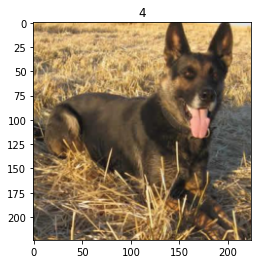

In [29]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

#### предсказания:

In [30]:
submission_df = pd.DataFrame.from_dict({'name': test_img_paths, 'label': test_predictions})
submission_df['name'] = submission_df['name'].str.replace('test/unknown/', '')
submission_df.head()

,name,label
0,0.jpeg,37
1,1.jpeg,23
2,10.jpeg,33
3,100.jpeg,10
4,1000.jpeg,29


In [31]:
submission_df.to_csv('./submission.csv', index=False, header = False)

## отчет
#### модель показала себя хорошо (> 93%), ожидаю того же на тестовой выборке!